<div class="frontmatter text-center">
<h1> DNDS 6005:Data Mining and Big Data Analytics</h1>
<h2>Final project: Detecting Spammers in Chinese Microblog Sina Weibo</h2>
<h3>Central European University, Winter 2018/2019</h3>
<h3>Name: Hao CUI</h3>
</div>

In [4]:
import pandas as pd
import numpy as np
import codecs
import networkx as nx
import matplotlib.pyplot as plt
import jieba
import jieba.posseg as pseg
#import os
#import sys
from sklearn import feature_extraction
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Read in the follower_followee.csv, with 'gbk' encoding as df1.

In [5]:
df1=pd.read_csv("follower_followee.csv", encoding='gbk')

In [6]:
df1.tail()

,id,follower,follower_id,followee,followee_id,guanzhu,fensi,post_num,gender,first_or_last
142363,311633,中国神盾,1807972150,陆濛,1933466191,724,286,796,male,first
142364,311634,南极章鱼松千代素,5268087406,陆濛,1933466191,166,178,661,female,first
142365,311635,人海尽头123,5103935052,陆濛,1933466191,113,10,242,male,first
142366,311636,三戒三三三,1946057551,陆濛,1933466191,983,1039060,2878,male,first
142367,311637,体香女生,3612353947,陆濛,1933466191,84,132602,129,female,first


#### Check the null values in the dataframe.

In [7]:
df1.isnull().sum()

id                 0
follower         110
follower_id        0
followee          74
followee_id        0
guanzhu            0
fensi              0
post_num           0
gender             0
first_or_last      0
dtype: int64

#### Check the dimension of df1.

In [5]:
df1.shape

(142368, 10)

### Read in the post.csv with 'gb2312' encoding as df2.

In [49]:
df2=pd.read_csv(r"post.csv",encoding='gb2312')

In [50]:
df2.head()

,post_id,scratch_time,post_time,content,image,poster,poster_id,poster_url,repost_num,comment_num,repost_post_id
0,3.777580e+15,2014/11/17 10:30,2014/11/16 16:45,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,http://tp1.sinaimg.cn/2364770064/50/22844411852/1,新百伦商城,2364770064,http://weibo.com/527loveyou,0,0,NaN
1,3.777620e+15,2014/11/17 15:45,2014/11/16 19:58,【奥汀羽酵素反馈】效果不好也不会卖这么好。正常吃饭，不用节食，不用运动，健康绿色没有副作用。...,http://tp3.sinaimg.cn/2346769694/50/5704078058/0,孚禾静静_,2346769694,http://weibo.com/206445959,0,0,NaN
2,3.777620e+15,2014/11/17 20:08,2014/11/16 19:58,我有话说【世界最穷总统拒绝酋长高价收购其老旧座驾】共产党员？http://t.cn/RzvUwBM,http://tp2.sinaimg.cn/2747799853/50/0/1,IT经济学,2747799853,http://weibo.com/u/2747799853,0,0,NaN
3,3.777620e+15,2014/11/17 20:08,2014/11/16 19:57,【蚕丝皂】吸附黑头的能力一级棒，清洁不选它是你没眼光[撇嘴][撇嘴]西游记申请吉尼斯百元哥被...,http://tp3.sinaimg.cn/2346769694/50/5704078058/0,孚禾静静_,2346769694,http://weibo.com/206445959,0,0,NaN
4,3.777620e+15,2014/11/17 20:09,2014/11/16 19:57,我活得很好！//【世界最穷总统拒绝酋长高价收购其老旧座驾】http://t.cn/RzvUwDk,http://tp2.sinaimg.cn/5136475477/50/0/1,很久很久58172,5136475477,http://weibo.com/u/5136475477,0,0,NaN


### Read in the weibo_user.xlsx dataset as df4.

In [8]:
df4=pd.read_excel("weibo_user.xlsx")
df4.head()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
0,1041514813,james1002,http://tp2.sinaimg.cn/1041514813/180/5708899731/1,male,5,Lv.5 浙江宁波 简介：诚信为本，站的高才能看的远。快乐开心每一天。,1557.0,1421.0,2000.0,NaN
1,1046222077,郑钧,http://tp2.sinaimg.cn/1046222077/180/5711167576/1,male,10,北京东城区 简介：且把悲歌欢唱 个性域名： zhengjun 博客地址： h...,1265.0,1280571.0,130.0,NaN
2,1049591831,波播阿波思密达,http://tp4.sinaimg.cn/1049591831/180/5710224593/0,female,5,Lv.5 吉林松原 1972年12月3日 简介：自由人，快乐族,503.0,302.0,968.0,NaN
3,1062050703,霞儿0109,http://tp4.sinaimg.cn/1062050703/180/1277084329/0,female,9,Lv.9 福建厦门 毕业于 厦门大学 公司 ChinaZ站长...,281.0,148.0,354.0,NaN
4,1071429143,紫荆花_18423,http://tp4.sinaimg.cn/1071429143/180/400610658...,female,5,Lv.5 广东湛江 毕业于 辽宁师范大学 公司 大学教师 ...,135.0,1975.0,2000.0,NaN


#### Check the null values in df4. We have noticed that many labels are missing in the original dataset.

In [9]:
df4.isnull().sum()

user_id           0
user_name         2
user_image        0
gender            0
class             0
message           1
post_num          6
follower_num      6
followee_num      6
is_spammer      603
dtype: int64

#### Check the dimension of df4.

In [10]:
df4.shape

(781, 10)

#### See the gender ratio difference in df4.

In [11]:
df4["gender"].value_counts()

female    468
male      313
Name: gender, dtype: int64

#### In the original dataset, is_spammer is manually annotated label, 1 means spammer and -1 means non-spammer;
#### Create dataframes of spammers and non-spammers. Check how many are spammers and how many are non-spammers. 

In [12]:
is_spammer=df4.loc[df4['is_spammer'] == 1.0]
len(is_spammer)

112

In [13]:
not_spammer=df4.loc[df4['is_spammer'] == -1.0]
len(not_spammer)

66

In [448]:
is_spammer.head()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
11,1195264701,双双留头发,http://tp2.sinaimg.cn/1195264701/180/5692904347/0,female,9,Lv.9 北京东城区 12月16日 简介：可爱温柔的幼儿园老师！,603.0,141.0,392.0,1.0
48,1402869242,智者钓鱼,http://tp3.sinaimg.cn/1402869242/180/5652278099/1,male,5,Lv.5 北京朝阳区 标签 汽车 IT数码 新闻资讯 旅游 时...,149.0,463.0,952.0,1.0
50,1465128481,gtg合恒浩yr,http://tp2.sinaimg.cn/1465128481/180/5646037674/1,male,0,Lv.0 其他,33.0,208.0,1833.0,1.0
51,1487256502,窜撒呀布拉格,http://tp3.sinaimg.cn/1487256502/180/5633968341/1,male,6,Lv.6 广东东莞 1993年12月22日 简介：能去理性面对ba.....,557.0,60.0,1528.0,1.0
72,1638396745,一浅浅一000,http://tp2.sinaimg.cn/1638396745/180/5708155126/0,female,1,Lv.1 其他,107.0,160.0,916.0,1.0


#### Check the gender difference in the spammer dataframe.

In [14]:
is_spammer["gender"].value_counts()

female    81
male      31
Name: gender, dtype: int64

#### Check the class distribution of the spammers.

In [48]:
is_spammer["class"].value_counts()

3    21
2    21
4    13
1    13
5    11
7    10
0    10
6     8
9     3
8     2
Name: class, dtype: int64

In [15]:
81/31 #2.6129032258064515

2.6129032258064515

#### Dataframe of non-spammers.

In [16]:
not_spammer.head()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
55,1504709690,寇蔻Flute,http://tp3.sinaimg.cn/1504709690/180/5708061943/0,female,7,Lv.7 ?寳????湞é??? ??????? ?????é?????...,820.0,342.0,387.0,-1.0
61,1588859384,朱勤文,http://tp1.sinaimg.cn/1588859384/180/5666876605/1,male,5,Lv.5 江苏苏州 毕业于 沈阳理工大学 公司 博世汽车部件...,311.0,146.0,155.0,-1.0
65,1606071642,饭团子柒小柒,http://tp3.sinaimg.cn/1606071642/180/5703050974/0,female,12,Lv.12 上海徐汇区 毕业于 上海大学 公司 无 双...,5628.0,603.0,2001.0,-1.0
90,1680755467,向日葵qll,http://tp4.sinaimg.cn/1680755467/180/5637848492/0,female,6,Lv.6 江苏南京 毕业于 南京中医药大学 简介：宅，喜欢音乐，...,284.0,43.0,59.0,-1.0
93,1695220825,midoodoo,http://tp2.sinaimg.cn/1695220825/180/5709860285/0,female,11,?洓?ˇ?垚é? 1987???5?湀4?? ???????????°???湡??...,2426.0,513.0,528.0,-1.0


#### Check the gender difference in the non-spammer dataframe.

In [17]:
not_spammer["gender"].value_counts()

female    48
male      18
Name: gender, dtype: int64

#### Check the class distribution of the non-spammers.

In [47]:
not_spammer["class"].value_counts()

4     15
7     10
6      7
5      7
2      7
8      5
3      4
11     3
10     3
12     2
0      2
1      1
Name: class, dtype: int64

In [18]:
48/18 #2.6666666666666665

2.6666666666666665

#### Make a list of the spammers whose data provided in the original dataset df4.

In [19]:
spammerlist=list(is_spammer['user_id'].unique())

In [20]:
len(spammerlist) #112

112

### Assumption1: the followers of the spammers are also spammers.
#### Make an edgelist of the spammers and the followers of the spammers through df1.

In [21]:
spam_edge=[]
for i in range(len(spammerlist)):
    temp_df=df1.loc[df1['followee_id'] == str(spammerlist[i])][['follower_id','followee_id']]
    spam_edge.append(temp_df)
spam_edge_df=pd.concat(spam_edge)
spam_edge_df.shape #(8477, 2)

(8477, 2)

In [22]:
spam_edge_df.tail()

,follower_id,followee_id
73361,3258988970,5365515981
73362,5325119935,5365515981
73363,5247510769,5365515981
73364,1972444615,5365515981
73365,2671109275,5365515981


#### Create a spammers' directed follower-followee graph

In [23]:
G_spam=nx.from_pandas_edgelist(spam_edge_df, 'follower_id', 'followee_id', create_using=nx.DiGraph())

In [24]:
len(G_spam.nodes()) #7079

7079

In [25]:
len(G_spam.edges()) #7189

7189

In [27]:
nx.write_gml(G_spam, "g_spam_new.gml")

#### In df4, the user_id type is numpy.int64

In [28]:
type(df4.iloc[0]['user_id'])

numpy.int64

#### Make a list of potential spammers in df4. Potential spammers are the followers of spammers.

In [29]:
potential_spam=[]

for i in range(len(list(G_spam.nodes()))):
    if list(G_spam.nodes())[i] in df4['user_id'].unique():
        temp= df4.loc[df4['user_id'] == list(G_spam.nodes())[i] ]
        potential_spam.append(temp)
    
potential_spam_df=pd.concat(potential_spam)
potential_spam_df.shape   #(133, 10)

/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


(133, 10)

In [30]:
potential_spam_df.head()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
325,2364770064,新百伦商城,http://tp1.sinaimg.cn/2364770064/180/228444118...,male,9,Lv.9 北京丰台区 1993年4月20日 简介：耐克，阿迪，新百伦，...,841.0,5608.0,1440.0,NaN
706,5146083784,他很陈很冠希,http://tp1.sinaimg.cn/5146083784/180/400651997...,male,4,Lv.4 北京东城区 公司 深圳市滔搏商贸有限公司 1994年1...,287.0,27258.0,807.0,NaN
735,5281501167,潘凤才,http://tp4.sinaimg.cn/5281501167/180/400667362...,male,4,Lv.4 江苏连云港 简介：潘凤才；学历；大专技术职称；兽医师。性别；男年...,1736.0,721.0,2047.0,NaN
778,5365515981,爱白马湖朱立荣,http://tp2.sinaimg.cn/5365515981/180/228904753...,female,0,Lv.0 广西来宾 1993年1月29日,15.0,8.0,285.0,1.0
511,3118752457,手机用户3118752457,http://tp2.sinaimg.cn/3118752457/180/5709650284/1,male,0,Lv.0 浙江,0.0,33.0,1332.0,NaN


#### Strangely, in the potential spammer dataframe, there are also users initially labeled as non-spammers.

In [32]:
potential_spam_df["is_spammer"].value_counts()

-1.0    21
 1.0    21
Name: is_spammer, dtype: int64

In [33]:
potential_spam_df["gender"].value_counts()

female    100
male       33
Name: gender, dtype: int64

#### See the class distribution of the potential spammers.

In [35]:
potential_spam_df["class"].value_counts()

7     21
5     17
4     15
0     12
11    10
6     10
10     9
2      9
9      8
8      8
3      8
1      6
Name: class, dtype: int64

In [36]:
100/33 #3.0303030303030303

3.0303030303030303

#### It is strange there are non-spammers that follow the spammers. In reality, in the original dataset, some non-spammers might be mistakenly labeled. Here we use the original label if a user is labeled as -1.0 (the non-spammer). For the NaN labeled users which are the followers of spammers, we label them as 1.0, the spammer.

In [37]:
potential_spam_df.loc[potential_spam_df['is_spammer'] == -1.0].tail()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
351,2459502185,爱吃肉的Panda000,http://tp2.sinaimg.cn/2459502185/180/5624895507/0,female,7,Lv.7 其他 简介： 标签 旅游 娱乐 美女 时尚 美食,740.0,236.0,575.0,-1.0
55,1504709690,寇蔻Flute,http://tp3.sinaimg.cn/1504709690/180/5708061943/0,female,7,Lv.7 ?寳????湞é??? ??????? ?????é?????...,820.0,342.0,387.0,-1.0
689,5089043599,蜜糖n,http://tp4.sinaimg.cn/5089043599/180/5708779709/0,female,5,Lv.5 其他,17.0,13.0,86.0,-1.0
141,1781048255,_Prodding,http://tp4.sinaimg.cn/1781048255/180/5671117005/0,female,11,Lv.11 ???寳?????? ?¤?????§ ??????????...,3553.0,221.0,862.0,-1.0
441,2833489233,四季良木,http://tp2.sinaimg.cn/2833489233/180/5696601808/0,female,4,Lv.4 其他 1996年10月2日,114.0,42.0,120.0,-1.0


### Assumption 2: the followees of non-spammers are also non-spammers. 

#### Similarly, make a list of the potential non-spammers.

Make a list of the spammers whose data provided in the original dataset.

In [38]:
nonspammerlist=list(not_spammer['user_id'].unique())

#### There are 66 labeled non-spammers in the original dataset.

In [39]:
len(nonspammerlist) #66

66

In [40]:
type(df1.iloc[0]['follower_id']) #numpy.int64

numpy.int64

#### Make an non-spammer follower-followee edgelist.

In [41]:
nonspam_edge=[]
for i in range(len(nonspammerlist)):
    temp_df=df1.loc[df1['follower_id'] == nonspammerlist[i]][['follower_id','followee_id']]
    nonspam_edge.append(temp_df)
nonspam_edge_df=pd.concat(nonspam_edge)
nonspam_edge_df.shape #(6507, 2)

(6507, 2)

In [42]:
nonspam_edge_df.head()

,follower_id,followee_id
26469,1504709690,5085868082
34400,1504709690,2106897347
34401,1504709690,1836018861
34402,1504709690,1917583785
34403,1504709690,3001712967


#### Build the non-spammers' directed network.

In [43]:
G_nonspam=nx.from_pandas_edgelist(nonspam_edge_df, 'follower_id', 'followee_id', create_using=nx.DiGraph())

In [44]:
len(G_nonspam.nodes()) #4850

4850

In [45]:
len(G_nonspam.edges()) #5772

5772

In [481]:
nx.write_gml(G_nonspam, "g_nonspam.gml")

#### Make a list of potential non-spammers in df4. Potential non-spammers are the followers of non-spammers.

In [46]:
potential_nonspam=[]

for i in range(len(list(G_nonspam.nodes()))):
    if list(G_nonspam.nodes())[i] in df4['user_id'].unique():
        temp= df4.loc[df4['user_id'] == list(G_nonspam.nodes())[i] ]
        potential_nonspam.append(temp)
    
potential_nonspam_df=pd.concat(potential_nonspam)
potential_nonspam_df.shape   

/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


(66, 10)

#### However, sadly, we haven't found new potential non-spammer in df4. So that we will label all the users mannually.

### Read in the user_post.xlsx as df3.

In [51]:
df3=pd.read_excel("user_post.xlsx")
df3.head()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,repost_post_id,inner_flag,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,3.744660e+15,2014-08-17 21:00:00,置顶#代理须知#拒绝泛滥，我不会每天一直更新图片的，图片有专门的地方，为了不影响其他顾客正常...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.777580e+15,2014-11-16 16:45:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.777570e+15,2014-11-16 16:29:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.777570e+15,2014-11-16 16:19:00,爆美来袭独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicsh...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.777570e+15,2014-11-16 16:11:00,独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicshoesQ...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### See the dimension of df3.

In [52]:
df3.shape #(48813, 37)

(48813, 37)

#### Subset the dataframe of df3, take only the first 7 columns as df3_new.

In [53]:
df3_new = df3.iloc[:,0:7]

In [54]:
df3_new.head()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num
0,3.744660e+15,2014-08-17 21:00:00,置顶#代理须知#拒绝泛滥，我不会每天一直更新图片的，图片有专门的地方，为了不影响其他顾客正常...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
1,3.777580e+15,2014-11-16 16:45:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
2,3.777570e+15,2014-11-16 16:29:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
3,3.777570e+15,2014-11-16 16:19:00,爆美来袭独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicsh...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
4,3.777570e+15,2014-11-16 16:11:00,独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicshoesQ...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0


#### Check the null values in df3_new.

In [55]:
df3_new.isnull().sum()

post_id        8368
post_time      8369
content        9288
poster_id      9052
poster_url     9053
repost_num     9053
comment_num    9053
dtype: int64

In [56]:
null_columns=df3_new.columns[df3_new.isnull().any()]

df3_new[df3_new.isnull().any(axis=1)][null_columns].head()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num
326,3.773890e+15,2014-11-06 12:58:00,NaN,5.154084e+09,http://weibo.com/5154084070,0.0,0.0
432,3.769180e+15,2014-10-24 12:44:00,NaN,3.558604e+09,http://weibo.com/3558603802,0.0,0.0
434,3.769150e+15,2014-10-24 10:30:00,我拍了段MV，欢迎围观。点此播放&gt,NaN,NaN,NaN,NaN
487,3.777560e+15,2014-11-16 16:02:00,我的皮肤属于油性肌肤，油脂分泌旺盛，粗大的毛孔以及黑头一直困扰我，自从使用了这款佰草世家猪鼻...,NaN,NaN,NaN,NaN
488,3.777520e+15,2014-11-16 13:23:00,尼玛~~鼻子上都是密密麻麻的黑头，啥化妆品都试了没用。幸好闺蜜推荐介去黑头神器，黑头和粉刺通...,NaN,NaN,NaN,NaN


#### Columns that contain NaN are not very useful. It is useless if we know nothing about the poster_id and so on. It is better we just delete all rows that contain null values.

In [57]:
df3_new1 = df3_new.dropna(how='any',axis=0) 
df3_new1.isnull().sum()

post_id        0
post_time      0
content        0
poster_id      0
poster_url     0
repost_num     0
comment_num    0
dtype: int64

#### We get the deleted NaN dataframe df3_new1.

In [58]:
df3_new1.shape #(38841, 7)

(38841, 7)

In [59]:
df3_new1.head()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num
0,3.744660e+15,2014-08-17 21:00:00,置顶#代理须知#拒绝泛滥，我不会每天一直更新图片的，图片有专门的地方，为了不影响其他顾客正常...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
1,3.777580e+15,2014-11-16 16:45:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
2,3.777570e+15,2014-11-16 16:29:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
3,3.777570e+15,2014-11-16 16:19:00,爆美来袭独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicsh...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0
4,3.777570e+15,2014-11-16 16:11:00,独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicshoesQ...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0


In [60]:
type(df3_new1.iloc[0]["poster_url"]) # the poster_url is str

str

#### Check how many unique users are there in df3_new1.

In [61]:
len(df3_new1["poster_url"].unique())  # 431 unique users

431

### Extract the user ids in from the url.

In [62]:
url="http://weibo.com/2364770064"
domain=url.split('//')[-1].split('/')[1]
print(domain)

2364770064


In [63]:
type(domain) #str

str

#### Define a function to extract user ids from the url.

In [64]:
def id_extract(url):
    domain=url.split('//')[-1].split('/')[1]
    return domain

In [65]:
df3_new1['User_ID']=df3_new1['poster_url'].apply(id_extract)  

/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Create a new columns to store User_ID.

In [66]:
df3_new1.head()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,User_ID
0,3.744660e+15,2014-08-17 21:00:00,置顶#代理须知#拒绝泛滥，我不会每天一直更新图片的，图片有专门的地方，为了不影响其他顾客正常...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,2364770064
1,3.777580e+15,2014-11-16 16:45:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,2364770064
2,3.777570e+15,2014-11-16 16:29:00,爆美来袭独家实拍质量看的见招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：a...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,2364770064
3,3.777570e+15,2014-11-16 16:19:00,爆美来袭独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicsh...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,2364770064
4,3.777570e+15,2014-11-16 16:11:00,独家实拍招微信代理一件代发专卖国际品牌名鞋品质赢得市场诚信赚得人心V信：asicshoesQ...,2.364770e+09,http://weibo.com/2364770064,0.0,0.0,2364770064


#### See the messages of the spammers

In [67]:
content_spammer=[]

for i in range(len(spammerlist)):
    if  str(spammerlist[i]) in df3_new1['User_ID'].unique():
        temp= df3_new1.loc[df3_new1['User_ID'] == str(spammerlist[i]) ]
        content_spammer.append(temp)
    
content_spammer_df=pd.concat(content_spammer)
content_spammer_df.shape  #(5024, 8)

(5024, 8)

In [68]:
content_spammer_df.tail()

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,User_ID
30697,3.776980e+15,2014-11-15 01:28:00,全国神经病等级测试题！还敢说自己不是“深井冰”？,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30698,3.776810e+15,2014-11-14 14:21:00,全国神经病等级测试题！还敢说自己不是“深井冰”？,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30699,3.776640e+15,2014-11-14 02:54:00,【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30700,3.776510e+15,2014-11-13 18:32:00,在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30701,3.776410e+15,2014-11-13 11:19:00,在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981


In [69]:
5365515981 in spammerlist

True

#### When considering the spammers' followers, we didn't find their followers in this dataframe (Since we got the same results as above).

In [70]:
content_spam=[]

for i in range(len(list(G_spam.nodes()))):
    if list(G_spam.nodes())[i] in df3_new1['User_ID'].unique():
        temp= df3_new1.loc[df3_new1['User_ID'] == list(G_spam.nodes())[i] ]
        content_spam.append(temp)
    
content_spam_df=pd.concat(content_spam)
content_spam_df.shape #(5024, 8)

(5024, 8)

In [71]:
len(content_spam_df["User_ID"].unique()) #63

63

### Now, we analyse the texts of the spammers.

In [72]:
content_spam_df['content'].tail()

30697                             全国神经病等级测试题！还敢说自己不是“深井冰”？
30698                             全国神经病等级测试题！还敢说自己不是“深井冰”？
30699    【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...
30700    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...
30701    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...
Name: content, dtype: object

### Read in the manually labeled dataset weibo_userwithlabel.xlsx (just added labels to dataset4) as df4_new.
Also specify values for the few missing values.

In [73]:
df4_new=pd.read_excel("weibo_userwithlabel.xlsx")
df4_new.head()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer
0,1041514813,james1002,http://tp2.sinaimg.cn/1041514813/180/5708899731/1,male,5,Lv.5 浙江宁波 简介：诚信为本，站的高才能看的远。快乐开心每一天。,1557,1421,2000,-1
1,1046222077,郑钧,http://tp2.sinaimg.cn/1046222077/180/5711167576/1,male,10,北京东城区 简介：且把悲歌欢唱 个性域名： zhengjun 博客地址： h...,1265,1280571,130,-1
2,1049591831,波播阿波思密达,http://tp4.sinaimg.cn/1049591831/180/5710224593/0,female,5,Lv.5 吉林松原 1972年12月3日 简介：自由人，快乐族,503,302,968,-1
3,1062050703,霞儿0109,http://tp4.sinaimg.cn/1062050703/180/1277084329/0,female,9,Lv.9 福建厦门 毕业于 厦门大学 公司 ChinaZ站长...,281,148,354,-1
4,1071429143,紫荆花_18423,http://tp4.sinaimg.cn/1071429143/180/400610658...,female,5,Lv.5 广东湛江 毕业于 辽宁师范大学 公司 大学教师 ...,135,1975,2000,-1


In [75]:
df4_new.isnull().sum()

user_id         0
user_name       0
user_image      0
gender          0
class           0
message         0
post_num        0
follower_num    0
followee_num    0
is_spammer      0
dtype: int64

#### Check the dimension of df4_new.

In [76]:
df4_new.shape

(781, 10)

#### Check the numbers of spammers and non-spammers.

In [77]:
df4_new['is_spammer'].value_counts()

-1    623
 1    158
Name: is_spammer, dtype: int64

#### Around 20% are spammers.

In [78]:
158/781

0.2023047375160051

#### Define a function to convert the message sentences to tokens.

In [79]:
def to_token(s):
    token_s='  '.join(jieba.cut(s,cut_all = False))
    return token_s

#### Test the correctness of the function.

In [80]:
df4_new.iloc[500]['message']

'   Lv.3     香港其他   简介：在当前现实的狭隘基础上，有高尚理想，全面的计划；在一步一步行动上，想到远大前途，脚踏实地地稳步前进，才能有所成就  '

In [81]:
a=df4_new.iloc[500]['message']

In [82]:
to_token(a)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/9q/q7_71c2561vfbg9lrq7m0_n80000gn/T/jieba.cache
Loading model cost 1.319 seconds.
Prefix dict has been built succesfully.


'         Lv.3                 香港  其他           简介  ：  在  当前  现实  的  狭隘  基础  上  ，  有  高尚  理想  ，  全面  的  计划  ；  在  一步  一步  行动  上  ，  想到  远大  前途  ，  脚踏实地  地  稳步前进  ，  才能  有所  成就      '

#### Create a new column in df4_new to store the tokened messages.

In [83]:
df4_new['token_message']=df4_new['message'].apply(to_token)  

In [84]:
df4_new.tail()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer,token_message
776,5364782215,股股生平123,http://tp4.sinaimg.cn/5364782215/180/228907024...,female,0,Lv.0 北京东城区 1982年3月16日 简介：我的微博每日开盘前半...,11,18,162,1,Lv.0 北京 东城区 ...
777,5365323976,德鑫--荷香,http://tp1.sinaimg.cn/5365323976/180/400711900...,female,2,广东深圳 毕业于 武汉科技大学 公司 深圳市德鑫资产管理有限公司 ...,16,176,1075,1,广东 深圳 毕业 于 武汉 科技 大学...
778,5365515981,爱白马湖朱立荣,http://tp2.sinaimg.cn/5365515981/180/228904753...,female,0,Lv.0 广西来宾 1993年1月29日,15,8,285,1,Lv.0 广西 来宾 ...
779,5365519449,雷神暴走JK,http://tp2.sinaimg.cn/5365519449/180/228904754...,female,0,Lv.0 福建 1991年9月28日,15,11,271,-1,Lv.0 福建 199...
780,5372497984,淑女superman,http://tp1.sinaimg.cn/5372497984/180/5711090912/0,female,0,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...,1,4,67,-1,Lv.0 山东 潍坊 ...


In [85]:
df4_new.iloc[-49]['token_message']

'         Lv.1                 上海浦东新区              毕业  于        上海交通大学              双性恋           简介  ：  我  一定  会  找到  他  ，  那片  传说  已久  的  幸福  森林  ~  ~           个性  域名  ：     xpyl8         '

### Text as a set of features
Transform from text to numeric data. Start by separating out our X and Y data.

In [86]:
X_text = df4_new['token_message']
Y = df4_new['is_spammer']

Turn X_text into X -- a numeric representation.

In [87]:
# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

### Modeling
We have a ton of features, let's use them in some different models.

In [88]:
# Create a model
svm = SVC(kernel='rbf', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.702


In [89]:
# Create a model
svm = SVC(kernel='linear', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.702


In [90]:
# Create a model
svm = SVC(kernel='poly', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.68


In [91]:
# Create a model
svm = SVC(kernel='sigmoid', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.708


#### Let's try using TF-IDF.

In [93]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

In [94]:
# Create a model
svm = SVC(kernel='rbf', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.691


In [95]:
# Create a model
svm = SVC(kernel='linear', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.704


In [96]:
# Create a model
svm = SVC(kernel='sigmoid', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.691


In [97]:
# Create a model
svm = SVC(kernel='poly', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.564


### Random forest
#### CountVectorizer

In [99]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=100)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.757


In [98]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.765


In [100]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=500)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.76


In [101]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200, max_depth=40)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.785


In [103]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200, max_depth=60)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.773


In [104]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200, max_depth=20)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.78


In [102]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200, max_depth=80)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.774


#### Using random forest and CountVectorizer, the best one is when n_estimators=200 and max_depth=40

In [105]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

In [108]:
# Create a model

rdf=RandomForestClassifier(n_estimators=100)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.707


In [109]:
# Create a model

rdf=RandomForestClassifier(n_estimators=200)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.712


In [106]:
# Create a model

rdf=RandomForestClassifier(n_estimators=200, max_depth=20)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.745


In [107]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=40)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.728


In [110]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=80)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.723


In [112]:
rdf=RandomForestClassifier(n_estimators=500, max_depth=20)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.752


### Now we try to improve the text mining classification results by considering the spammers contents in dataframe df3.

In [113]:
len(tfidf_vectorizer.fit(X_text).vocabulary_.keys())

3517

#### Create new spammer dataframe.

In [114]:
IS_spammer=df4_new.loc[df4_new['is_spammer'] == 1.0]
IS_spammer.shape

(158, 11)

In [115]:
IS_spammer["gender"].value_counts()

female    112
male       46
Name: gender, dtype: int64

In [116]:
IS_spammer['class'].value_counts()

2     27
7     26
3     26
0     21
1     19
4     14
5     10
6      8
9      4
11     2
8      1
Name: class, dtype: int64

#### A list of the new spammers.

In [117]:
SPAMMERlist=list(IS_spammer['user_id'].unique())
len(SPAMMERlist) #158

158

### See the messages of the spammers in df3_new1

In [118]:
content_SPAMMER=[]

for i in range(len(SPAMMERlist)):
    if  str(SPAMMERlist[i]) in df3_new1['User_ID'].unique():
        temp= df3_new1.loc[df3_new1['User_ID'] == str(SPAMMERlist[i]) ]
        content_SPAMMER.append(temp)
    
content_SPAMMER_df=pd.concat(content_SPAMMER)
content_SPAMMER_df.shape  #(6604, 8)

(6604, 8)

In [119]:
content_SPAMMER_df[-5:]

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,User_ID
30697,3.776980e+15,2014-11-15 01:28:00,全国神经病等级测试题！还敢说自己不是“深井冰”？,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30698,3.776810e+15,2014-11-14 14:21:00,全国神经病等级测试题！还敢说自己不是“深井冰”？,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30699,3.776640e+15,2014-11-14 02:54:00,【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30700,3.776510e+15,2014-11-13 18:32:00,在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981
30701,3.776410e+15,2014-11-13 11:19:00,在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...,5.365516e+09,http://weibo.com/5365515981,0.0,0.0,5365515981


#### 83 spammers exist in df3

In [120]:
len(content_SPAMMER_df["User_ID"].unique()) #83

83

#### Spammer list in df3.

In [121]:
spammer_list_df3=content_SPAMMER_df["User_ID"].unique()

#### Make a dictionary such that the keys are the spammers' User_ID, and the values are the aggregated contents of the spammers.

In [122]:
spamcontent_dict=dict()
for i in range(len(spammer_list_df3)):
    spamcontent_dict[spammer_list_df3[i]]=str(content_SPAMMER_df.loc[content_SPAMMER_df['User_ID'] == spammer_list_df3[i]]['content'])

In [124]:
spamcontent_dict['5365515981']

'30687    热门【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图...\n30688                  【读心术】超级精准的读心测试，一分钟读出你最假的一面，你有勇气试试吗？\n30689                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30690                                  【读心小测试】你的外表和内心哪个更美?\n30691                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30692    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30693                                          【你会和谁结婚】很准哦\n30694                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30695           右手食指指纹决定了你的爱情！吖，你还别不信，看过的木有人说不准滴。不信，你试试！！！\n30696    【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图画下...\n30697                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30698                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30699    【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...\n30700    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30701    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\nName: content, dtype: object'

#### Add the spammers' messages in the spamcontent_dict to the dataframe in df4_new.

In [125]:
list(spamcontent_dict.keys())[-1]

'5365515981'

In [126]:
spammer_list_df3[-1]

'5365515981'

In [178]:
spamcontent_dict[spammer_list_df3[-1]]

'30687    热门【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图...\n30688                  【读心术】超级精准的读心测试，一分钟读出你最假的一面，你有勇气试试吗？\n30689                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30690                                  【读心小测试】你的外表和内心哪个更美?\n30691                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30692    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30693                                          【你会和谁结婚】很准哦\n30694                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30695           右手食指指纹决定了你的爱情！吖，你还别不信，看过的木有人说不准滴。不信，你试试！！！\n30696    【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图画下...\n30697                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30698                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30699    【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...\n30700    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30701    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\nName: content, dtype: object'

In [127]:
df4_new.tail()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer,token_message
776,5364782215,股股生平123,http://tp4.sinaimg.cn/5364782215/180/228907024...,female,0,Lv.0 北京东城区 1982年3月16日 简介：我的微博每日开盘前半...,11,18,162,1,Lv.0 北京 东城区 ...
777,5365323976,德鑫--荷香,http://tp1.sinaimg.cn/5365323976/180/400711900...,female,2,广东深圳 毕业于 武汉科技大学 公司 深圳市德鑫资产管理有限公司 ...,16,176,1075,1,广东 深圳 毕业 于 武汉 科技 大学...
778,5365515981,爱白马湖朱立荣,http://tp2.sinaimg.cn/5365515981/180/228904753...,female,0,Lv.0 广西来宾 1993年1月29日,15,8,285,1,Lv.0 广西 来宾 ...
779,5365519449,雷神暴走JK,http://tp2.sinaimg.cn/5365519449/180/228904754...,female,0,Lv.0 福建 1991年9月28日,15,11,271,-1,Lv.0 福建 199...
780,5372497984,淑女superman,http://tp1.sinaimg.cn/5372497984/180/5711090912/0,female,0,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...,1,4,67,-1,Lv.0 山东 潍坊 ...


#### We have realized that when using loc on the dataframe to get the message of a user, many messages are missing and replaced by "..."

In [128]:
print(df4_new.loc[df4_new['user_id'] == 5372497984]['message'])

780       Lv.0     山东潍坊   2000年12月3日    标签  新闻趣事  名人明...
Name: message, dtype: object


#### While using iloc on the dataframe will return the full message.

In [129]:
print(df4_new.iloc[-1]['message'])

   Lv.0     山东潍坊   2000年12月3日    标签  新闻趣事  名人明星  美食  校园生活  潍坊生活   


#### Even if we use the index function will still return us the incomplete message.

In [130]:
ind=df4_new.index[df4_new["user_id"]== 5372497984]

In [131]:
df4_new.iloc[ind]['message']

780       Lv.0     山东潍坊   2000年12月3日    标签  新闻趣事  名人明...
Name: message, dtype: object

#### We thus define a function to get the index integer corresponding to the user_id.

In [132]:
b="Int64Index(["
c="], dtype='int64')"
d=str(df4_new.index[df4_new["user_id"]== 5372497984]).replace(b, "").replace(c, "")
d

'780'

In [133]:
def get_index(n):
    b="Int64Index(["
    c="], dtype='int64')"
    d=str(df4_new.index[df4_new["user_id"]== n]).replace(b, "").replace(c, "")
    return int(d)

#### Test the correctness of our function. It shows the complete message.

In [134]:
df4_new.iloc[get_index(5372497984)]['message']

'   Lv.0     山东潍坊   2000年12月3日    标签  新闻趣事  名人明星  美食  校园生活  潍坊生活   '

#### Define a function that adds the spammers' new messages from df3 to df4_new if the spammers exist in df3. For other users, the message remain unchanged.

In [135]:
def newspam_message(n):
    #a = '\nName: message, dtype: object'

    if str(n) in list(spamcontent_dict.keys()):
        #new=spamcontent_dict[str(n)]+str(df4_new.loc[df4_new['user_id'] == n]['message']).replace(a, '')
        new=spamcontent_dict[str(n)]+df4_new.iloc[get_index(n)]['message']
    else:
        #new=str(df4_new.loc[df4_new['user_id'] == n]['message']).replace(a, '')
        new=df4_new.iloc[get_index(n)]['message']
    return new

#### Test the correctness of our function.

In [136]:
"5365515981" in list(spamcontent_dict.keys())

True

In [137]:
newspam_message(5365515981)

'30687    热门【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图...\n30688                  【读心术】超级精准的读心测试，一分钟读出你最假的一面，你有勇气试试吗？\n30689                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30690                                  【读心小测试】你的外表和内心哪个更美?\n30691                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30692    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30693                                          【你会和谁结婚】很准哦\n30694                           【读心术】神奇的素描图像测试你的内心世界，准的可怕！\n30695           右手食指指纹决定了你的爱情！吖，你还别不信，看过的木有人说不准滴。不信，你试试！！！\n30696    【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，都很准。我把这个图画下...\n30697                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30698                             全国神经病等级测试题！还敢说自己不是“深井冰”？\n30699    【你适合跟谁在一起】据说经过这个测试的情侣不会分手；你和她将是最完美的酸碱中和，永远在一起。...\n30700    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\n30701    在这个基情四射，蕾丝满天的时代里，你还能100%确认你的性向么？做个测试看看再拍拖吧，以免害...\nName: content, dtype: object   Lv.0     广西来宾   1993年1月29日  '

In [138]:
"5372497984" in list(spamcontent_dict.keys())

False

In [139]:
print(newspam_message(5372497984))

   Lv.0     山东潍坊   2000年12月3日    标签  新闻趣事  名人明星  美食  校园生活  潍坊生活   


### Add a new column to df4_new that contains all the updated new messages of the spammers. 

In [140]:
df4_new['updated_message']=df4_new['user_id'].apply(newspam_message)  
df4_new.tail()

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer,token_message,updated_message
776,5364782215,股股生平123,http://tp4.sinaimg.cn/5364782215/180/228907024...,female,0,Lv.0 北京东城区 1982年3月16日 简介：我的微博每日开盘前半...,11,18,162,1,Lv.0 北京 东城区 ...,48642 热门201...
777,5365323976,德鑫--荷香,http://tp1.sinaimg.cn/5365323976/180/400711900...,female,2,广东深圳 毕业于 武汉科技大学 公司 深圳市德鑫资产管理有限公司 ...,16,176,1075,1,广东 深圳 毕业 于 武汉 科技 大学...,广东深圳 毕业于 武汉科技大学 公司 深圳市德鑫资产管理有限公司 ...
778,5365515981,爱白马湖朱立荣,http://tp2.sinaimg.cn/5365515981/180/228904753...,female,0,Lv.0 广西来宾 1993年1月29日,15,8,285,1,Lv.0 广西 来宾 ...,30687 热门【读心术】一个据说能看穿你的人性和欲望的心理测试！这个测验测过无数人，...
779,5365519449,雷神暴走JK,http://tp2.sinaimg.cn/5365519449/180/228904754...,female,0,Lv.0 福建 1991年9月28日,15,11,271,-1,Lv.0 福建 199...,Lv.0 福建 1991年9月28日
780,5372497984,淑女superman,http://tp1.sinaimg.cn/5372497984/180/5711090912/0,female,0,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...,1,4,67,-1,Lv.0 山东 潍坊 ...,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...


#### Now we create a new column to store the tokened updated_message in our datafram.

In [141]:
df4_new['token_updatedmessage']=df4_new['updated_message'].apply(to_token)  

In [143]:
df4_new[-2:]

,user_id,user_name,user_image,gender,class,message,post_num,follower_num,followee_num,is_spammer,token_message,updated_message,token_updatedmessage
779,5365519449,雷神暴走JK,http://tp2.sinaimg.cn/5365519449/180/228904754...,female,0,Lv.0 福建 1991年9月28日,15,11,271,-1,Lv.0 福建 199...,Lv.0 福建 1991年9月28日,Lv.0 福建 199...
780,5372497984,淑女superman,http://tp1.sinaimg.cn/5372497984/180/5711090912/0,female,0,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...,1,4,67,-1,Lv.0 山东 潍坊 ...,Lv.0 山东潍坊 2000年12月3日 标签 新闻趣事 名人明...,Lv.0 山东 潍坊 ...


#### The updated_messages indeed incoporated new spam messages and tokened.

In [144]:
df4_new.iloc[get_index(5365515981)]['token_updatedmessage']

'30687              热门  【  读心术  】  一个  据说  能  看穿  你  的  人性  和  欲望  的  心理  测试  ！  这个  测验  测过  无数  人  ，  都  很准  。  我  把  这个  图  ...  \n  30688                                                        【  读心术  】  超级  精准  的  读心  测试  ，  一分钟  读出  你  最假  的  一面  ，  你  有  勇气  试试  吗  ？  \n  30689                                                                                   【  读心术  】  神奇  的  素描  图像  测试  你  的  内心世界  ，  准  的  可怕  ！  \n  30690                                                                                                        【  读心  小  测试  】  你  的  外表  和  内心  哪个  更美  ?  \n  30691                                                                                         全国  神经病  等级  测试题  ！  还敢  说  自己  不是  “  深井  冰  ”  ？  \n  30692              在  这个  基情  四射  ，  蕾丝  满天  的  时代  里  ，  你  还  能  100%  确认  你  的  性  向  么  ？  做个  测试  看看  再  拍拖  吧  ，  以免  害  ...  \n  30693                                                                                                                          

In [145]:
df4_new.iloc[get_index(5365519449)]['token_updatedmessage']

'         Lv.0                 福建           1991  年  9  月  28  日      '

### Now we are ready to run the machine learning algorithm on the updated messages and the target.

#### Text as a set of features

In [146]:
X_text = df4_new['token_updatedmessage']
Y = df4_new['is_spammer']

In [147]:
# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

### Modeling

In [148]:
# Create a model
svm = SVC(kernel='rbf', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.857


In [150]:
# Create a model
svm = SVC(kernel='linear', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.809


In [151]:
# Create a model
svm = SVC(kernel='sigmoid', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.866


In [152]:
# Create a model
svm = SVC(kernel='poly', gamma='scale') 

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.771


#### Let's try using TF-IDF.

In [154]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

# Create a model
svm = SVC(kernel='rbf', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.788


In [155]:
# Create a model
svm = SVC(kernel='linear', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.802


In [157]:
# Create a model
svm = SVC(kernel='sigmoid', gamma='scale')

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(svm, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.788


### GaussianNB

In [158]:
from sklearn.naive_bayes import GaussianNB

In [159]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model
nbc = GaussianNB()

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(nbc, X.toarray(), Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.721


#### Try using TF-IDF.

In [160]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

# Create a model
nbc = GaussianNB()

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(nbc, X.toarray(), Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.691


### Random forest

In [161]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model

rdf=RandomForestClassifier(n_estimators=200)
#nbc = GaussianNB()

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.867


In [162]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=40)
#nbc = GaussianNB()

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.877


In [167]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=60, random_state=0)
#nbc = GaussianNB()

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.875


In [168]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=80, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.882


In [169]:
rdf=RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.855


In [166]:
rdf=RandomForestClassifier(n_estimators=500, max_depth=40, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.881


#### Try using TF-IDF.

In [170]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

# Create a model
rdf=RandomForestClassifier(n_estimators=100)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.855


In [171]:
# Create a model
rdf=RandomForestClassifier(n_estimators=200)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.861


In [172]:
# Create a model
rdf=RandomForestClassifier(n_estimators=200, max_depth=80, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.868


In [173]:
# Create a model
rdf=RandomForestClassifier(n_estimators=200, max_depth=40, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.878


In [174]:
# Create a model
rdf=RandomForestClassifier(n_estimators=200, max_depth=120, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.863


In [175]:
# Create a model
rdf=RandomForestClassifier(n_estimators=500, max_depth=20, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.88


In [176]:
# Create a model
rdf=RandomForestClassifier(n_estimators=500, max_depth=80, random_state=0)

# Use this model and our data to get 5-fold cross validation AUCs
aucs = cross_val_score(rdf, X, Y, scoring="roc_auc", cv=5)

# Print out the average AUC rounded to three decimal points
print("Area under the ROC curve for our classifier is " + str(round(np.mean(aucs), 3)))

Area under the ROC curve for our classifier is 0.87


### Build machine learning classifiers using other features.

In [177]:
df4sub_new=df4_new[['gender', 'class', 'post_num', 'follower_num', 'followee_num', 'is_spammer']]
label_encoder = LabelEncoder()

mf = label_encoder.fit_transform(df4sub_new['gender'])  #1:male 0:female

In [178]:
df4sub_new['gender']=mf

/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [179]:
df4sub_new.head()

,gender,class,post_num,follower_num,followee_num,is_spammer
0,1,5,1557,1421,2000,-1
1,1,10,1265,1280571,130,-1
2,0,5,503,302,968,-1
3,0,9,281,148,354,-1
4,0,5,135,1975,2000,-1


In [180]:
y = df4sub_new['is_spammer'].values        
X = df4sub_new.drop(['is_spammer'], axis=1)

#### Plot the scatter plots between all features.

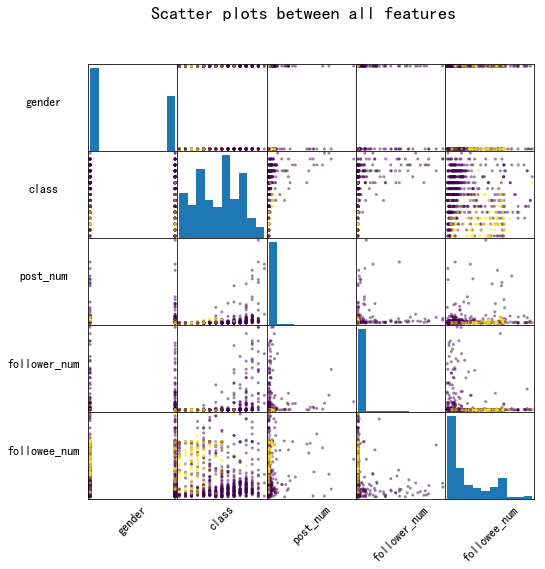

In [181]:
sm=pd.plotting.scatter_matrix(X, c=y, figsize=(8, 8));
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

[plt.setp(item.yaxis.get_label(), 'size', 12) for item in sm.ravel()]
#x labels
[plt.setp(item.xaxis.get_label(), 'size', 12) for item in sm.ravel()]

plt.suptitle("Scatter plots between all features", fontsize=18)
plt.show()

#### Plot boxplots of unscaled and scaled data.

In [182]:
def plot_coxbox(X, columns_names, title=None):
    n_columns = len(columns_names)
    fig = plt.figure(figsize=(max(6, n_columns/3),max(6,n_columns/3)))
    ax = fig.add_subplot(111)
    ax.boxplot(X)
    plt.xticks(np.arange(1, n_columns + 1), columns_names, rotation=30, ha="right")
    if title:
        plt.title(title)

Text(0.5,1,'Unscaled data')

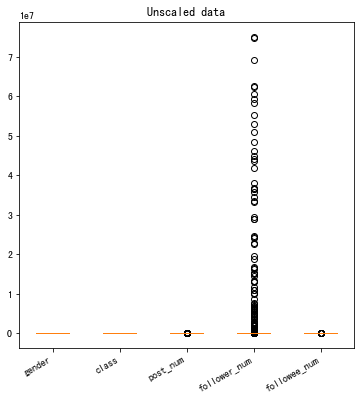

In [183]:
plot_coxbox(X.values, X.columns)
plt.title("Unscaled data")

#### Since many celebrities with huge number of followers exist, we should scale our dataset.

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,1,'Scaled data by MinMaxScaler')

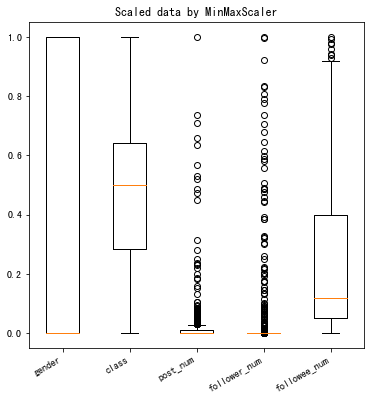

In [184]:
scaler = MinMaxScaler().fit(X.values)
X_scaled = scaler.transform(X.values)
plot_coxbox(X_scaled, X.columns)
plt.title("Scaled data by MinMaxScaler")

#### Scalers and different classifiers.

In [185]:
scale_methods = [StandardScaler(), RobustScaler(), MinMaxScaler()]

models = [DecisionTreeClassifier(random_state=43), 
          KNeighborsClassifier()] #, RandomForestClassifier()

for model in models:
    print(type(model).__name__)
    reference_score = np.average(cross_val_score(model, X, y, cv=5))
    
    for scaler in scale_methods:
        X_scaled = scaler.fit_transform(X)
        print('%s=> %f (%f)' %(type(scaler).__name__, 
                               np.average(cross_val_score(model, X_scaled, y, cv=5)), 
                               reference_score))
    print()

DecisionTreeClassifier
StandardScaler=> 0.793589 (0.802638)
RobustScaler=> 0.803912 (0.802638)
MinMaxScaler=> 0.793655 (0.802638)

KNeighborsClassifier
StandardScaler=> 0.824409 (0.843534)
RobustScaler=> 0.846197 (0.843534)
MinMaxScaler=> 0.825716 (0.843534)



/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 

### Logistic Regression

In [186]:
from sklearn.linear_model import LogisticRegression 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

logisticRegr = LogisticRegression()

logisticRegr.fit(X_train_scaled, y_train)
score=logisticRegr.score(X_test_scaled, y_test)

print("Test score: {:.3f}".format(score))

Test score: 0.821


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Measuring Model Performance

In [187]:
from sklearn import metrics

# Make predictions on test data
predictions = logisticRegr.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test, predictions)

### Confusion Matrix

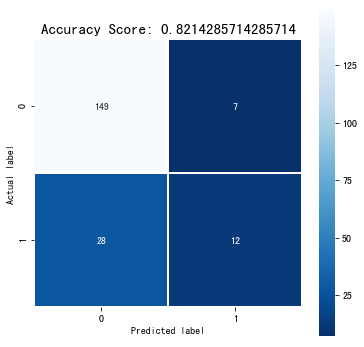

In [188]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Hyperparameter Optimization

In [221]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }


grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver="liblinear"), #CV cross validation
                           param_grid, 
                           cv=5, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Test set score: 0.8214
Best parameters: {'C': 1000}
Best cross-validation score: 0.87
Best estimator:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy on the testing set: 0.8214


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.1s finished


In [191]:
# compute minimum and maximum on the training data
scaler = StandardScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converg

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Test set score: 0.8214
Best parameters: {'C': 100}
Best cross-validation score: 0.85
Best estimator:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy on the testing set: 0.8214


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [190]:
# compute minimum and maximum on the training data
scaler = RobustScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Test set score: 0.8418
Best parameters: {'C': 100}
Best cross-validation score: 0.88
Best estimator:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy on the testing set: 0.8418


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


#### Logistic Regression Pipeline-MinMaxScaler

In [222]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("Logreg", LogisticRegression(random_state=0, C=1))])

In [223]:
pipe.fit(X_train, y_train)

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Logreg', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [224]:
print("Test score: {:.3f}".format(pipe.score(X_test, y_test)))

Test score: 0.821


#### Logistic Regression Pipeline-StandardScaler

In [249]:
pipe = Pipeline([("scaler", StandardScaler()), ("Logreg", LogisticRegression(random_state=0, C=1000))])

In [250]:
pipe.fit(X_train, y_train)

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Logreg', LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [251]:
print("Test score: {:.3f}".format(pipe.score(X_test, y_test)))

Test score: 0.821


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Logistic Regression Pipeline-RobustScaler

In [237]:
pipe = Pipeline([("scaler", RobustScaler()), ("Logreg", LogisticRegression(random_state=0, C=100))])

In [238]:
pipe.fit(X_train, y_train)

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('Logreg', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [239]:
print("Test score: {:.3f}".format(pipe.score(X_test, y_test)))

Test score: 0.842


## Decision tree

### Validation curve for decision tree.

In [252]:
from sklearn.model_selection import validation_curve #accuracy and performance

param_range = range(1,5,1)

train_scores, test_scores = validation_curve(DecisionTreeClassifier(), 
                                             X, y, 
                                             "max_depth", 
                                             param_range, 
                                             cv=5)

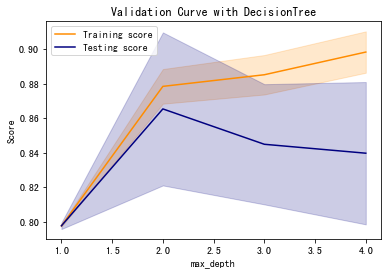

In [253]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DecisionTree")
plt.xlabel("max_depth")
plt.ylabel("Score")

plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.plot(param_range, test_scores_mean, label="Testing score", color="navy")

plt.fill_between(param_range, 
                 train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange")

plt.fill_between(param_range, 
                 test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy")

plt.legend()
plt.show() 

### Plot the learning curve. It shows the validation and training score of the estimator for varying numbers of training samples

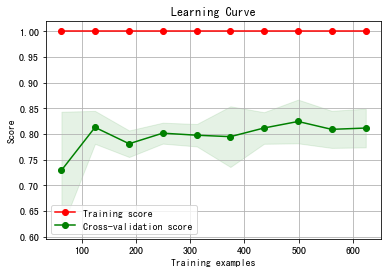

In [254]:
from sklearn.model_selection import learning_curve

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(), X, y, cv=5, train_sizes=np.linspace(.1, 1, 10)) #linear uniform division

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### Hyperparameter Optimization

In [385]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,5,1), 'min_impurity_decrease':np.arange(0,1,0.01)}


grid_search = GridSearchCV(DecisionTreeClassifier(), #CV cross validation
                           param_grid, 
                           cv=10, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Test set score: 0.8520
Best parameters: {'max_depth': 2, 'min_impurity_decrease': 0.0}
Best cross-validation score: 0.88
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy on the testing set: 0.8520


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    7.3s finished


In [386]:
final_model = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'], 
                                     min_impurity_decrease=grid_search.best_params_['min_impurity_decrease'])
final_model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Decision tree pipeline

In [387]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("Decision tree", DecisionTreeClassifier(max_depth=2))])

In [388]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('Decision tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [389]:
print("Decision tree pipeline test score: {:.3f}".format(pipe.score(X_test, y_test)))

Decision tree pipeline test score: 0.852


## KNeighborsClassifier

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [391]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

knn = KNeighborsClassifier()
# learn an KNeighborsClassifier on the scaled training data
knn.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)

print("Test score: {:.4f}".format(knn.score(X_test_scaled, y_test)))

Test score: 0.8112


### Hyperparameter Optimization

#### MinMaxScaler

In [392]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1,30,1)}


grid_search = GridSearchCV(KNeighborsClassifier(), #CV cross validation
                           param_grid, 
                           cv=10, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 29 candidates, totalling 290 fits
Test set score: 0.8163
Best parameters: {'n_neighbors': 7}
Best cross-validation score: 0.87
Best estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')
Accuracy on the testing set: 0.8163


[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    1.8s finished


#### StandardScaler

In [393]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1,30,1)}


grid_search = GridSearchCV(KNeighborsClassifier(), #CV cross validation
                           param_grid, 
                           cv=10, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = StandardScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/Users/cuihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 29 candidates, totalling 290 fits
Test set score: 0.8061
Best parameters: {'n_neighbors': 27}
Best cross-validation score: 0.86
Best estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=27, p=2,
           weights='uniform')
Accuracy on the testing set: 0.8061


[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    2.2s finished


#### RobustScaler

In [394]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1,30,1)}


grid_search = GridSearchCV(KNeighborsClassifier(), #CV cross validation
                           param_grid, 
                           cv=10, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = RobustScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


grid_search.fit(X_train_scaled, y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled, y_test)))

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test set score: 0.8418
Best parameters: {'n_neighbors': 10}
Best cross-validation score: 0.88
Best estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
Accuracy on the testing set: 0.8418


[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    1.8s finished


#### RobustScaler performs the best among all scalers, with n_neighbors 10 and testing set accuracy 0.8418.

### KNeighborsClassifier Pipelines
#### MinMaxScaler

In [397]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsClassifier(n_neighbors=7))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8163


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### StandardScaler

In [398]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=27))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8061


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### RobustScaler

In [404]:
pipe = Pipeline([("scaler", RobustScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8418


#### By using the KNeighborsClassifier pipelines, we got the same as previous results.

## SVC-linear kernel
#### MinMaxScaler

In [255]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import train_test_split

model = SVC(kernel='linear')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train.astype(np.float64))           

# rescale the training data
X_train_scaled = scaler.transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

#Train the model using the training sets
model.fit(X_train_scaled.astype(np.float64), y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test_scaled.astype(np.float64))

print("Accuracy:",metrics.accuracy_score(y_test.astype(np.float64), y_pred))

Accuracy: 0.8214285714285714


#### StandardScaler

In [256]:
model = SVC(kernel='linear')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = StandardScaler().fit(X_train.astype(np.float64))            

# rescale the training data
X_train_scaled = scaler.transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

#Train the model using the training sets
model.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test_scaled)

print("Accuracy:",metrics.accuracy_score(y_test.astype(np.float64), y_pred))

Accuracy: 0.8163265306122449


#### RobustScaler

In [257]:
model = SVC(kernel='linear')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = RobustScaler().fit(X_train)        

# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train the model using the training sets
model.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test_scaled)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8418367346938775


### SVC pipelines

#### MinMaxScaler

In [258]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("SVC", SVC(kernel='linear'))])
pipe.fit(X_train.astype(np.float64), y_train)
print("Test score: {:.4f}".format(pipe.score(X_test.astype(np.float64), y_test)))

Test score: 0.8214


In [268]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("SVC", SVC(kernel='rbf'))])
pipe.fit(X_train.astype(np.float64), y_train)
print("Test score: {:.4f}".format(pipe.score(X_test.astype(np.float64), y_test)))

Test score: 0.8061


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [269]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("SVC", SVC(kernel='sigmoid'))])
pipe.fit(X_train.astype(np.float64), y_train)
print("Test score: {:.4f}".format(pipe.score(X_test.astype(np.float64), y_test)))

Test score: 0.7959


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### StandardScaler

In [259]:
pipe = Pipeline([("scaler", StandardScaler()), ("SVC", SVC(kernel='linear'))])
pipe.fit(X_train.astype(np.float64), y_train)
print("Test score: {:.4f}".format(pipe.score(X_test.astype(np.float64), y_test)))

Test score: 0.8163


In [266]:
pipe = Pipeline([("scaler", StandardScaler()), ("SVC", SVC(kernel='sigmoid'))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.7806


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [267]:
pipe = Pipeline([("scaler", StandardScaler()), ("SVC", SVC(kernel='rbf'))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8214


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### RobustScaler

In [260]:
pipe = Pipeline([("scaler", RobustScaler()), ("SVC", SVC(kernel='linear'))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8418


In [262]:
pipe = Pipeline([("scaler", RobustScaler()), ("SVC", SVC(kernel='rbf'))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8367


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [263]:
pipe = Pipeline([("scaler", RobustScaler()), ("SVC", SVC(kernel='sigmoid'))])
pipe.fit(X_train, y_train)
print("Test score: {:.4f}".format(pipe.score(X_test, y_test)))

Test score: 0.8214


/Users/cuihao/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### The pipeline results of SVC with linear kernel are almost the same with the previous results. Higher scores are obtained by using RobustScaler.

## Random Forest

Random Forests don't need to scale the data, they are based on tree partitioning algorithms. Basically, any monotonic transformation of the data shouldn't change the forest at all (in the most common implementations).

In [270]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) # 70% training and 30% test # , test_size=0.3

RF = RandomForestClassifier(n_estimators=200, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
RF.fit(X_train,y_train)

y_pred_RF = RF.predict(X_test)

print("Random forest accuracy:",round(metrics.accuracy_score(y_test, y_pred_RF),4))

Random forest accuracy: 0.8367


### Hyperparameters optimization

In [271]:
param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(), #CV cross validation
                           param_grid, 
                           cv=10, 
                           verbose=1,
                           iid = False,
                           return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train.astype(np.float64))

# rescale the training data
X_train_scaled = scaler.transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))


grid_search.fit(X_train_scaled.astype(np.float64), y_train)

print("Test set score: {:.4f}".format(grid_search.score(X_test_scaled.astype(np.float64), y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
#real one in testing data
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test_scaled.astype(np.float64), y_test)))

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test set score: 0.8571
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score: 0.8905
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy on the testing set: 0.8571


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  3.9min finished


### Random forest pipeline

In [273]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("Random forest", RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100))])
pipe.fit(X_train.astype(np.float64), y_train)
print("Test score: {:.4f}".format(pipe.score(X_test.astype(np.float64), y_test)))

Test score: 0.8571


#### In summary, when considering the text, the classifiers that produce the highest accuracy is the random forest classifier using CountVectorizer, with n_estimators=200 and max_depth=80, yielding an accuracy of 0.882. 

#### When considering other features, the best classifier is the random forest with entropy criterion, max_depth=4, max_features='sqrt' and n_estimators=100.

#### For both SVC and KNN, the best performance are when using RobustScaler, giving accuracy 0.842.